<a href="https://colab.research.google.com/github/Dev-Tayal/music-genre-classification/blob/main/MusicGenreCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
%pip install librosa tensorflow scikit-learn matplotlib

In [12]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"developt","key":"720306c224e21e51f006632020ab2246"}'}

In [14]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [15]:
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

Dataset URL: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification
License(s): other
gtzan-dataset-music-genre-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [20]:
!unzip gtzan-dataset-music-genre-classification.zip

Archive:  gtzan-dataset-music-genre-classification.zip
replace Data/features_30_sec.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Data/features_30_sec.csv  
replace Data/features_3_sec.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Data/features_3_sec.csv  
  inflating: Data/genres_original/blues/blues.00000.wav  
  inflating: Data/genres_original/blues/blues.00001.wav  
  inflating: Data/genres_original/blues/blues.00002.wav  
  inflating: Data/genres_original/blues/blues.00003.wav  
  inflating: Data/genres_original/blues/blues.00004.wav  
  inflating: Data/genres_original/blues/blues.00005.wav  
  inflating: Data/genres_original/blues/blues.00006.wav  
  inflating: Data/genres_original/blues/blues.00007.wav  
  inflating: Data/genres_original/blues/blues.00008.wav  
  inflating: Data/genres_original/blues/blues.00009.wav  
  inflating: Data/genres_original/blues/blues.00010.wav  
  inflating: Data/genres_original/blues/blues.00011.wav  
  inflating: Data/genre

In [21]:
import os

data_path = "/content/Data/genres_original"
genres = os.listdir(data_path)
print("Genres:", genres)

# List some files from one genre
print("\nSample files from 'jazz':")
print(os.listdir(os.path.join(data_path, 'jazz'))[:5])

Genres: ['rock', 'classical', 'pop', 'metal', 'hiphop', 'jazz', 'country', 'blues', 'disco', 'reggae']

Sample files from 'jazz':
['jazz.00045.wav', 'jazz.00041.wav', 'jazz.00012.wav', 'jazz.00030.wav', 'jazz.00094.wav']


In [25]:
#Preprocess the audio into MFCCs and save as data.json
import math
import json
import librosa
import numpy as np

DATASET_PATH = "/content/Data/genres_original"
JSON_PATH = "data.json"
SAMPLES_PER_TRACK = 22050 * 30

def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=10):
    data = {
        "mapping": [],
        "mfcc": [],
        "labels": []
    }

    num_samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    expected_num_mfcc_vectors = math.ceil(num_samples_per_segment / hop_length)

    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        if dirpath != dataset_path:
            genre_label = dirpath.split("/")[-1]
            data["mapping"].append(genre_label)
            print(f"\nProcessing: {genre_label}")

            for f in filenames:
                file_path = os.path.join(dirpath, f)
                try:
                    signal, sr = librosa.load(file_path, sr=22050)
                except Exception as e:
                    print(f"Could not process file {file_path}: {e}")
                    continue


                for d in range(num_segments):
                    start = num_samples_per_segment * d
                    finish = start + num_samples_per_segment

                    mfcc = librosa.feature.mfcc(y=signal[start:finish], sr=sr,
                                                n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T

                    if len(mfcc) == expected_num_mfcc_vectors:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i - 1)

    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

    print("\n✅ Saved MFCCs to", json_path)

# Run preprocessing
save_mfcc(DATASET_PATH, JSON_PATH)



Processing: rock

Processing: classical

Processing: pop

Processing: metal

Processing: hiphop

Processing: jazz


/tmp/ipython-input-25-462219186.py:30: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(file_path, sr=22050)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Could not process file /content/Data/genres_original/jazz/jazz.00054.wav: 

Processing: country

Processing: blues

Processing: disco

Processing: reggae

✅ Saved MFCCs to data.json


In [26]:
import json
import numpy as np

DATA_PATH = "data.json"

def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y

X, y = load_data(DATA_PATH)
print(f"Data loaded. Shape of X: {X.shape}, Shape of y: {y.shape}")

Data loaded. Shape of X: (9986, 130, 13), Shape of y: (9986,)


In [27]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# reshape for CNN input: (samples, height, width, channels)
X = X[..., np.newaxis]

# one-hot encode labels
y = to_categorical(y)

# split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")


Train shape: (6990, 130, 13, 1), Validation shape: (1498, 130, 13, 1), Test shape: (1498, 130, 13, 1)


In [28]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=X.shape[1:]))
model.add(layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(10, activation='softmax'))  # 10 genres

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 11, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 6, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 4, 32)      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 2, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 31, 2, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1984)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       127,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,514 (537.16 KB)

 Trainable params: 137,386 (536.66 KB)

 Non-trainable params: 128 (512.00 B)

In [29]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=30,
                    batch_size=32)


Epoch 1/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 18s 68ms/step - accuracy: 0.3412 - loss: 1.9057 - val_accuracy: 0.4019 - val_loss: 1.6032
Epoch 2/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 23s 81ms/step - accuracy: 0.5088 - loss: 1.3541 - val_accuracy: 0.5801 - val_loss: 1.1784
Epoch 3/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 18s 69ms/step - accuracy: 0.5768 - loss: 1.1847 - val_accuracy: 0.5988 - val_loss: 1.1754
Epoch 4/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 21s 70ms/step - accuracy: 0.6094 - loss: 1.0763 - val_accuracy: 0.6235 - val_loss: 1.0415
Epoch 5/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 16s 71ms/step - accuracy: 0.6353 - loss: 1.0125 - val_accuracy: 0.6555 - val_loss: 1.0022
Epoch 6/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.6855 - loss: 0.8718 - val_accuracy: 0.6883 - val_loss: 0.8968
Epoch 7/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 21s 70ms/step - accuracy: 0.6876 - loss: 0.8313 - val_accuracy: 0.6856 - val_loss: 0.9267
Epoch 8/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 19s 66ms/step - accuracy: 0.7309 - loss: 0.7553 - 

In [30]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"\nTest accuracy: {test_acc:.4f}")


47/47 - 1s - 14ms/step - accuracy: 0.7437 - loss: 1.0388

Test accuracy: 0.7437


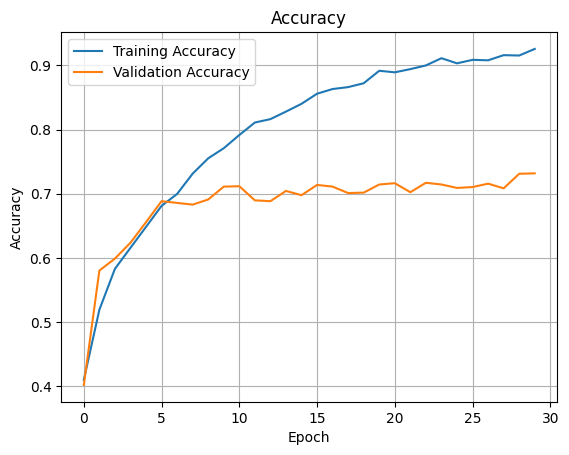

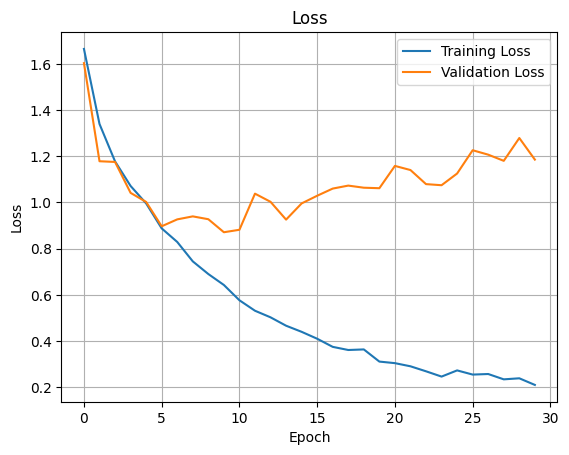

In [31]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
